# 데이터 불러오기

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
df = pd.read_csv('../csv/preprocess.csv')
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,date_of_birth_distinct_emails_4w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.9,0.642713,0.0,20,0.009624,105.898067,1724,7394.902554,8,...,1,0,0,1,0,0,0,1,0,0
1,0,0.9,0.720064,200.0,40,0.007018,33.006203,1986,5416.601990,5,...,1,0,0,1,0,0,0,0,1,0
2,0,0.9,0.075432,129.0,40,0.009764,-0.632448,2411,7423.819019,7,...,0,0,0,1,0,0,0,0,1,0
3,0,0.5,0.784344,240.0,20,0.017281,-1.612753,1731,4489.610329,8,...,1,0,0,1,0,1,0,0,0,0
4,0,0.8,0.770435,150.0,40,9.370346,26.733867,1863,6301.097061,7,...,0,0,0,1,0,1,0,0,0,0


# 분석

In [3]:
train_cols = df.columns[1:]
X = df[train_cols] # 독립변수
y = df["fraud_bool"] # 종속변수
df["fraud_bool"].value_counts()

0    6871
1    6871
Name: fraud_bool, dtype: int64

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler                                                                                                    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=0)),
    ])
params = {
    'clf__max_depth': list(range(3,6)),
    'clf__n_estimators': list(range(10,110,10)),
    'clf__max_leaf_nodes': list(range(3, 300, 5)),
    'clf__min_samples_split': list(range(2, 403, 10)),
    }
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

# params = {
#     'clf__max_depth': list(range(3,6)),
#     'clf__n_estimators': list(range(10,110,10)),
#     }
# {'clf__max_depth': 4, 'clf__n_estimators': 40}
# 0.7524390185777786

# params = {
#     'clf__max_depth': list(range(3,6)),
#     'clf__n_estimators': list(range(10,110,10)),
#     'clf__max_leaf_nodes': list(range(3, 300, 5)),
#     'clf__min_samples_split': list(range(2, 403, 10)),
#     }
# {'clf__max_depth': 3, 'clf__max_leaf_nodes': 8, 'clf__min_samples_split': 402, 'clf__n_estimators': 90}
# 0.7480718886025978

In [7]:
model = grid.best_estimator_['clf']
model.fit(X, y)

RandomForestClassifier(max_depth=3, max_leaf_nodes=8, min_samples_split=402,
                       n_estimators=90, random_state=0)

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y, model.predict(X)))



              precision    recall  f1-score   support

           0       0.75      0.82      0.79      6871
           1       0.80      0.73      0.77      6871

    accuracy                           0.78     13742
   macro avg       0.78      0.78      0.78     13742
weighted avg       0.78      0.78      0.78     13742



In [9]:
pred = grid.predict(X)

In [10]:
#confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, pred)
cm

array([[6099,  772],
       [2977, 3894]], dtype=int64)

In [11]:
df_cm=pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
df_cm

,0,1
0,6099,772
1,2977,3894


In [12]:
tpr = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[1,0])
fpr = df_cm.loc[0,1] / (df_cm.loc[0,1] + df_cm.loc[1,1])
precision = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[0,1])
recall = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[1,0])
f = (2 * (precision * recall)) / (precision + recall)
print(tpr, fpr, precision, recall, f)

0.6719920669898634 0.16545220745820832 0.8876437199825353 0.6719920669898634 0.764908760268389


# 시각화

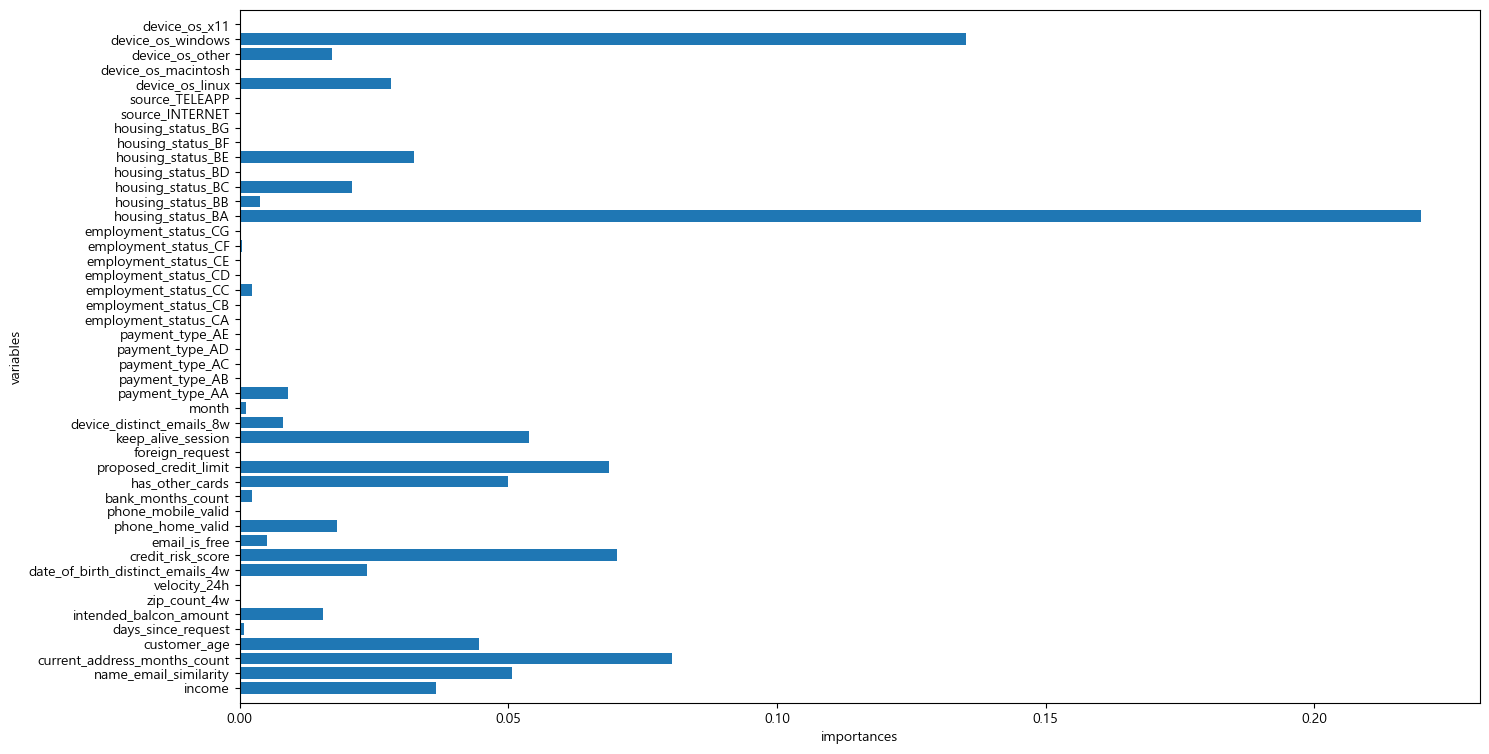

In [13]:
import numpy as np
def plot_tree(model):
    n_features = X.shape[1]
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_cols)
    plt.xlabel("importances")
    plt.ylabel("variables")
    plt.ylim(-1, n_features)
plot_tree(model)

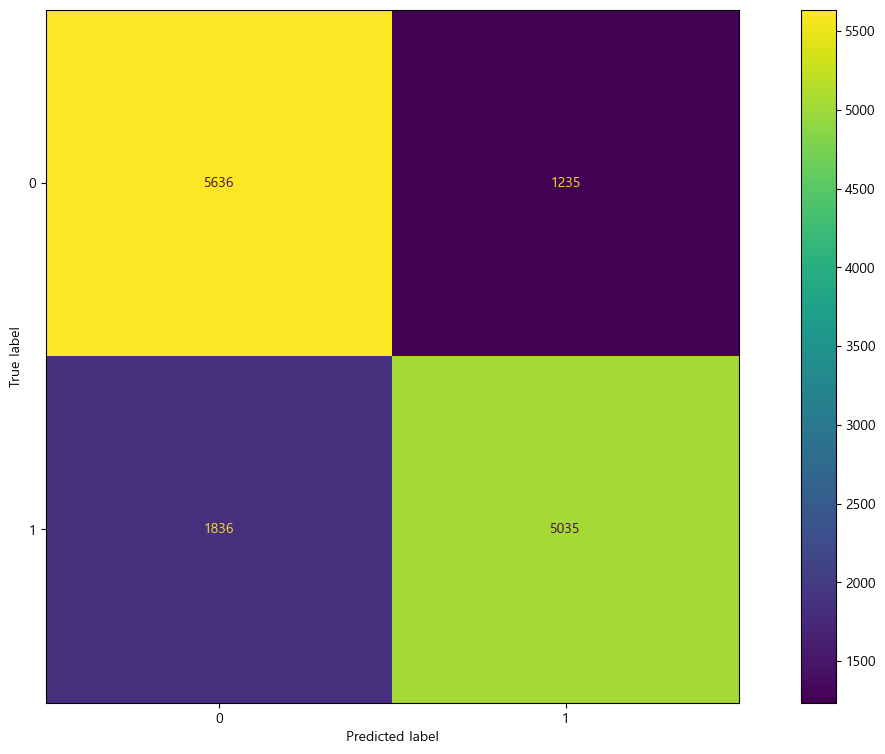

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, model.predict(X))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

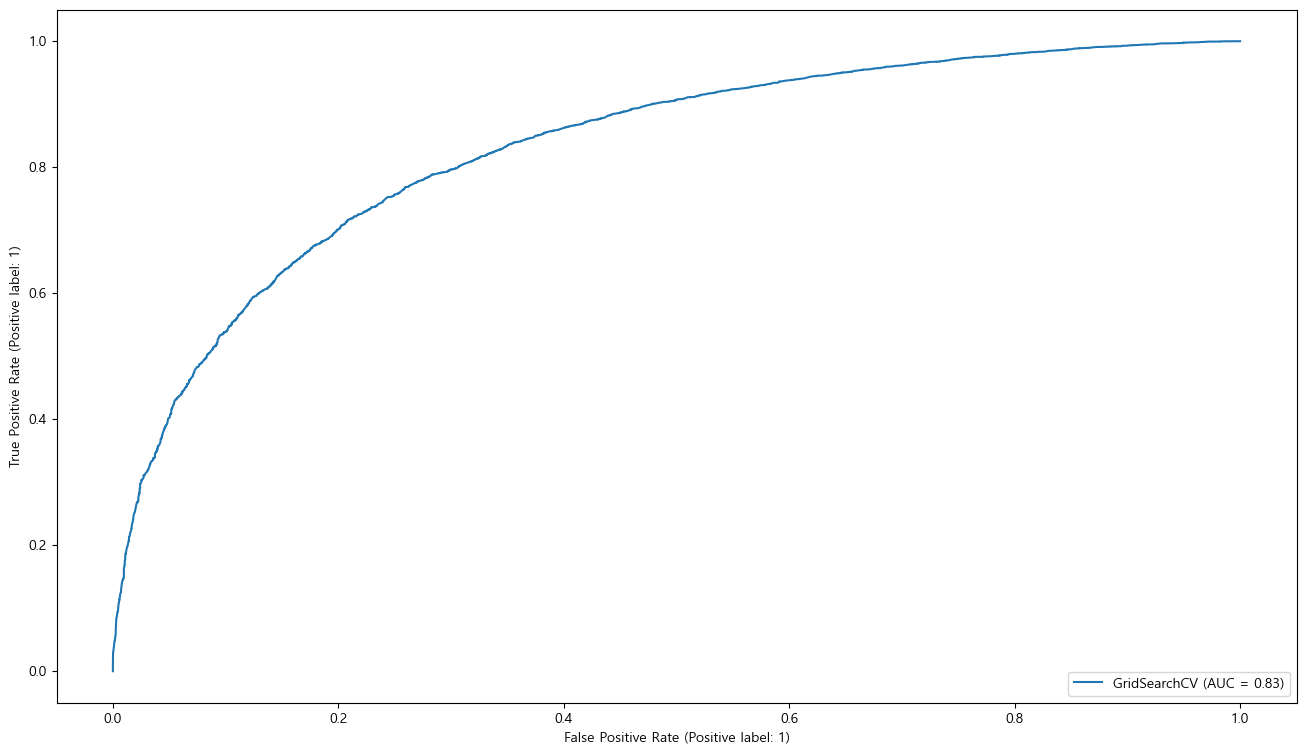

In [15]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(grid, X, y)

# 저장

In [16]:
result = pd.read_csv('../csv/model_results.csv')
result

,Model,Best Score,Best Parameter,Precision,Recall,F1-score,TPR,FPR,AUC
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we...",0.814874,0.778071,0.796047,0.778071,0.194317,0.87
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,...",0.851841,0.848753,0.850294,0.848753,0.148700,0.93
2,DNN,0.784456,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c...",0.831757,0.817714,0.824675,0.817714,0.171183,0.90
3,SVM,0.788968,"{'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__k...",0.942221,0.639913,0.762185,0.639913,0.109517,0.85
4,RF,0.748072,"{'clf__max_depth': 3, 'clf__max_leaf_nodes': 8...",0.887644,0.671992,0.764909,0.671992,0.165452,0.83
5,Logit,0.788022,"{'clf__C': 0.1, 'clf__class_weight': 1, 'clf__...",0.796827,0.758731,0.777312,0.758731,0.213914,0.85
6,Tree,0.714525,"{'clf__max_depth': 3, 'clf__max_leaf_nodes': 3...",0.622762,0.762745,0.685682,0.762745,0.318741,0.76


In [17]:
if 'RF' in result.Model.values.tolist():
    result.loc[result.Model.values.tolist().index('RF')] = ['RF', grid.best_score_, grid.best_params_, precision, recall, f, tpr, fpr, 0.83]
else:
    result.loc[len(result.index)] = ['RF', grid.best_score_, grid.best_params_, precision, recall, f, tpr, fpr, 0.83]
result

,Model,Best Score,Best Parameter,Precision,Recall,F1-score,TPR,FPR,AUC
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we...",0.814874,0.778071,0.796047,0.778071,0.194317,0.87
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,...",0.851841,0.848753,0.850294,0.848753,0.148700,0.93
2,DNN,0.784456,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c...",0.831757,0.817714,0.824675,0.817714,0.171183,0.90
3,SVM,0.788968,"{'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__k...",0.942221,0.639913,0.762185,0.639913,0.109517,0.85
4,RF,0.748072,"{'clf__max_depth': 3, 'clf__max_leaf_nodes': 8...",0.887644,0.671992,0.764909,0.671992,0.165452,0.83
5,Logit,0.788022,"{'clf__C': 0.1, 'clf__class_weight': 1, 'clf__...",0.796827,0.758731,0.777312,0.758731,0.213914,0.85
6,Tree,0.714525,"{'clf__max_depth': 3, 'clf__max_leaf_nodes': 3...",0.622762,0.762745,0.685682,0.762745,0.318741,0.76


In [18]:
result.to_csv('../csv/model_results.csv', index=None)

In [26]:
import joblib
joblib.dump(model, '../model/rf.h5')

['../model/rf.h5']